In [25]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from glob import glob
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import shutil
import joblib

In [21]:
# ------------------ CONFIGURACION ------------------
original_path = "E:/downloads/archive (12)/Train_images"
dataset_split_path = "E:/downloads/archive (12)/Dataset_split"

split_ratio = {
    'train': 0.6,
    'val': 0.15,
    'test': 0.25
}

label_map = {
    'Cigar-shaped smooth': 0,
    'completely round smooth': 1,
    'edge-on': 2,
    'In between smooth': 3,
    'spiral': 4
}

# ------------------ FUNCION PARA DIVIDIR EL DATASET ------------------
def split_dataset():
    for subset in split_ratio:
        for clase in label_map:
            subset_class_dir = os.path.join(dataset_split_path, subset, clase)
            os.makedirs(subset_class_dir, exist_ok=True)

    for clase in label_map:
        clase_path = os.path.join(original_path, clase)
        images = glob(os.path.join(clase_path, '*.jpg')) + \
                 glob(os.path.join(clase_path, '*.jpeg')) + \
                 glob(os.path.join(clase_path, '*.png'))

        random.shuffle(images)
        n_total = len(images)
        n_train = int(split_ratio['train'] * n_total)
        n_val = int(split_ratio['val'] * n_total)

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        for img_path in train_imgs:
            shutil.copy2(img_path, os.path.join(dataset_split_path, 'train', clase, os.path.basename(img_path)))
        for img_path in val_imgs:
            shutil.copy2(img_path, os.path.join(dataset_split_path, 'val', clase, os.path.basename(img_path)))
        for img_path in test_imgs:
            shutil.copy2(img_path, os.path.join(dataset_split_path, 'test', clase, os.path.basename(img_path)))

    print("\nDataset dividido en train (60%), val (15%) y test (25%) correctamente.")

# ------------------ EJECUTAR ------------------
split_dataset()



Dataset dividido en train (60%), val (15%) y test (25%) correctamente.


In [22]:
# ------------------ FUNCIONES DE FILTRADO ------------------
filtered_train_path = "E:/downloads/archive (12)/Filtered_train"
def filtro_prewitt(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    imgx = cv2.filter2D(gray, -1, kernelx)
    imgy = cv2.filter2D(gray, -1, kernely)
    return cv2.addWeighted(imgx, 0.5, imgy, 0.5, 0)

def filtro_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def filtro_bilateral(img):
    return cv2.bilateralFilter(img, 9, 75, 75)

def filtro_gaussiano(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def filtro_sobel(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = cv2.magnitude(sobelx, sobely)
    return cv2.convertScaleAbs(mag)

# ------------------ APLICAR FILTROS A TRAIN ------------------
def apply_filters_to_train():
    filtros = {
        'prewitt': filtro_prewitt,
        'clahe': filtro_clahe,
        'bilateral': filtro_bilateral,
        'gaussiano': filtro_gaussiano,
        'sobel': filtro_sobel
    }

    train_base = os.path.join(dataset_split_path, 'train')

    for filtro_nombre, filtro_func in filtros.items():
        for clase in label_map:
            input_cls_path = os.path.join(train_base, clase)
            output_cls_path = os.path.join(filtered_train_path, filtro_nombre, clase)
            os.makedirs(output_cls_path, exist_ok=True)

            image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                          glob(os.path.join(input_cls_path, '*.jpeg')) + \
                          glob(os.path.join(input_cls_path, '*.png'))

            for img_path in tqdm(image_paths, desc=f"Aplicando {filtro_nombre} - clase: {clase}"):
                img = cv2.imread(img_path)
                if img is None:
                    continue

                filtered_img = filtro_func(img)
                base_name = os.path.basename(img_path)
                save_path = os.path.join(output_cls_path, base_name)
                cv2.imwrite(save_path, filtered_img)

    print("\nFiltrado aplicado a las imágenes de entrenamiento.")

# ------------------ EJECUTAR ------------------
apply_filters_to_train()


Dataset dividido en train (60%), val (15%) y test (25%) correctamente.


Aplicando prewitt - clase: Cigar-shaped smooth: 100%|██████████| 487/487 [00:06<00:00, 72.99it/s]
Aplicando prewitt - clase: completely round smooth: 100%|██████████| 7091/7091 [01:21<00:00, 86.64it/s] 
Aplicando bilateral - clase: Cigar-shaped smooth: 100%|██████████| 487/487 [00:03<00:00, 143.15it/s]
Aplicando bilateral - clase: completely round smooth: 100%|██████████| 7091/7091 [00:57<00:00, 123.99it/s]
Aplicando gaussiano - clase: Cigar-shaped smooth: 100%|██████████| 487/487 [00:01<00:00, 302.32it/s]
Aplicando gaussiano - clase: completely round smooth: 100%|██████████| 7091/7091 [00:48<00:00, 146.13it/s]
Aplicando sobel - clase: spiral: 100%|██████████| 6534/6534 [00:49<00:00, 133.13it/s]


Filtrado aplicado a las imágenes de entrenamiento.


In [23]:
borders_train_path = "E:/downloads/archive (12)/Bordered_train"
# ------------------ FUNCIONES DE DETECCION DE BORDES ------------------
def aplicar_canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray, 100, 200)

def aplicar_laplacian(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    return np.uint8(np.absolute(lap))

def aplicar_otsu(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu

# ------------------ APLICAR FILTROS DE BORDE A TRAIN ------------------
def apply_edge_detectors_to_train():
    bordes = {
        'canny': aplicar_canny,
        'laplacian': aplicar_laplacian,
        'otsu': aplicar_otsu
    }

    train_base = os.path.join(dataset_split_path, 'train')

    for metodo_nombre, metodo_func in bordes.items():
        for clase in label_map:
            input_cls_path = os.path.join(train_base, clase)
            output_cls_path = os.path.join(borders_train_path, metodo_nombre, clase)
            os.makedirs(output_cls_path, exist_ok=True)

            image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                          glob(os.path.join(input_cls_path, '*.jpeg')) + \
                          glob(os.path.join(input_cls_path, '*.png'))

            for img_path in tqdm(image_paths, desc=f"Aplicando {metodo_nombre} - clase: {clase}"):
                img = cv2.imread(img_path)
                if img is None:
                    continue

                bordered_img = metodo_func(img)
                base_name = os.path.basename(img_path)
                save_path = os.path.join(output_cls_path, base_name)
                cv2.imwrite(save_path, bordered_img)

    print("\nDetección de bordes aplicada a las imágenes de entrenamiento.")

# ------------------ EJECUTAR ------------------
apply_edge_detectors_to_train()

Aplicando laplacian - clase: Cigar-shaped smooth: 100%|██████████| 487/487 [00:04<00:00, 114.29it/s]
Aplicando laplacian - clase: completely round smooth: 100%|██████████| 7091/7091 [00:46<00:00, 151.91it/s]
Aplicando otsu - clase: spiral: 100%|██████████| 6534/6534 [00:36<00:00, 177.99it/s]


Detección de bordes aplicada a las imágenes de entrenamiento.


In [28]:
equalized_train_path = "E:/downloads/archive (12)/Equalized_train"
# ------------------ FUNCION DE ECUALIZACION DE HISTOGRAMA ------------------
def apply_histogram_equalization_to_train():
    train_base = os.path.join(dataset_split_path, 'train')

    for clase in label_map:
        input_cls_path = os.path.join(train_base, clase)
        output_cls_path = os.path.join(equalized_train_path, clase)
        os.makedirs(output_cls_path, exist_ok=True)

        image_paths = glob(os.path.join(input_cls_path, '*.jpg')) + \
                      glob(os.path.join(input_cls_path, '*.jpeg')) + \
                      glob(os.path.join(input_cls_path, '*.png'))

        for img_path in tqdm(image_paths, desc=f"Ecualizando - clase: {clase}"):
            img = cv2.imread(img_path)
            if img is None:
                continue

            ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            y_channel, cr, cb = cv2.split(ycrcb)
            y_eq = cv2.equalizeHist(y_channel)
            ycrcb_eq = cv2.merge((y_eq, cr, cb))
            img_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

            base_name = os.path.basename(img_path)
            save_path = os.path.join(output_cls_path, base_name)
            cv2.imwrite(save_path, img_eq)

    print("\nEcualización de histograma aplicada a las imágenes de entrenamiento.")
apply_histogram_equalization_to_train()

Ecualizando - clase: spiral: 100%|██████████| 6534/6534 [00:45<00:00, 143.47it/s]


Ecualización de histograma aplicada a las imágenes de entrenamiento.


In [31]:
final_train_path = "E:/downloads/archive (12)/Final_train"
sift_descriptor_output = "E:/downloads/archive (12)/sift_descriptors.pkl"
classes = list(label_map.keys())

# ------------------ FUNCIONES DE COMBINACION Y SIFT ------------------
def combine_filtered_images():
    sources = [filtered_train_path, borders_train_path, equalized_train_path]
    for clase in label_map:
        dest_cls_path = os.path.join(final_train_path, clase)
        os.makedirs(dest_cls_path, exist_ok=True)

        for source in sources:
            for method in os.listdir(source):
                source_cls_path = os.path.join(source, method, clase) if os.path.isdir(os.path.join(source, method)) else os.path.join(source, clase)
                if not os.path.exists(source_cls_path):
                    continue

                image_paths = glob(os.path.join(source_cls_path, '*.*'))

                for img_path in image_paths:
                    filename = os.path.basename(img_path)
                    new_filename = f"{os.path.basename(source)}_{method}_{filename}" if os.path.isdir(os.path.join(source, method)) else f"{os.path.basename(source)}_{filename}"
                    new_path = os.path.join(dest_cls_path, new_filename)
                    shutil.copyfile(img_path, new_path)
    print("\nImágenes combinadas en carpeta final.")
combine_filtered_images()



Imágenes combinadas en carpeta final.


In [ ]:
def extract_sift_descriptors(dataset_dir):
    sift = cv2.SIFT_create(nfeatures=500)
    descriptors_list = []
    labels_list = []

    for cls in classes:
        cls_path = os.path.join(dataset_dir, cls)
        image_paths = glob(os.path.join(cls_path, '*.jpg')) + \
                      glob(os.path.join(cls_path, '*.jpeg')) + \
                      glob(os.path.join(cls_path, '*.png'))

        print(f"Procesando clase: {cls} ({len(image_paths)} imágenes)")

        for img_path in tqdm(image_paths):
            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            if descriptors is not None:
                descriptors_list.append(descriptors)
                labels_list.append(cls)

    print("\nExtracción de descriptores SIFT finalizada.")
    joblib.dump((descriptors_list, labels_list), sift_descriptor_output)
    print(f"Descriptores guardados en: {sift_descriptor_output}")


extract_sift_descriptors(final_train_path)

Procesando clase: Cigar-shaped smooth (3896 imágenes)


100%|██████████| 3896/3896 [01:51<00:00, 34.83it/s]


Procesando clase: completely round smooth (56728 imágenes)


100%|██████████| 56728/56728 [31:00<00:00, 30.49it/s]


Procesando clase: edge-on (26224 imágenes)


100%|██████████| 26224/26224 [13:33<00:00, 32.26it/s]


Procesando clase: In between smooth (54560 imágenes)


100%|██████████| 54560/54560 [27:49<00:00, 32.69it/s]


Procesando clase: spiral (52272 imágenes)


 72%|███████▏  | 37761/52272 [23:32<07:33, 32.00it/s]   


Aplicando: Bilateral + Sobel + Otsu


Clase Cigar-shaped smooth:   0%|          | 0/579 [00:00<?, ?it/s]

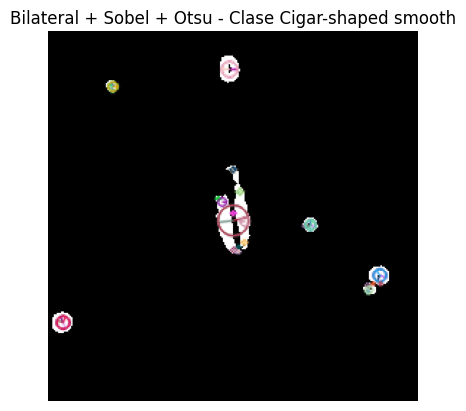

Clase Cigar-shaped smooth:   0%|          | 1/579 [00:00<01:22,  7.04it/s]

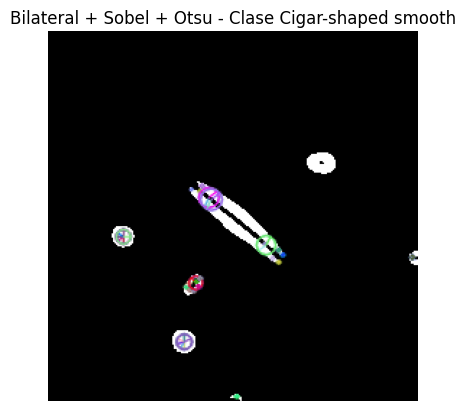

Clase Cigar-shaped smooth:   0%|          | 2/579 [00:00<01:10,  8.23it/s]

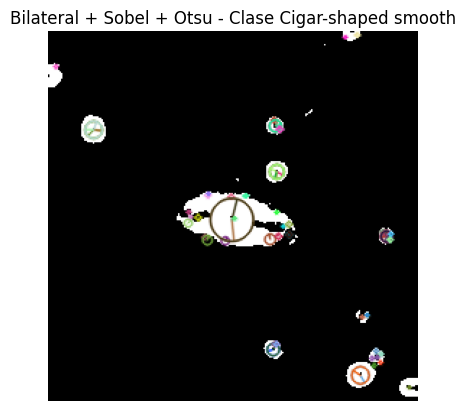

Clase Cigar-shaped smooth:  27%|██▋       | 158/579 [00:03<00:07, 53.01it/s]